# Data Exploration

## Description
A description will go here

### Data upload and curation

In [83]:
import pandas as pd
import json
import math
import numpy as np

from connect import Connect
from config import Config as cfg

#### Importing our data into a pandas DataFrame using our Connect module
Since

In [38]:
authUrl = "https://www.strava.com/oauth/token"
activitiesUrl = "https://www.strava.com/api/v3/athlete/activities"

conn = Connect(cfg.CLIENT_SECRET,
               cfg.CLIENT_ID,
               cfg.REFRESH_TOKEN)
payload = {
    "client_id": conn.clientID,
    "client_secret": conn.clientSecret,
    "refresh_token": conn.refreshToken,
    "grant_type": "refresh_token",
    "f": "json"
}

conn.refresh_token(authUrl, payload)
# print(conn.accessToken)
# print(conn.refreshToken)
page = 0
if conn.accessToken != "":
    data = conn.get_activities(activitiesUrl, page)
    
        
all_data_raw = pd.DataFrame()
page += 1
data = conn.get_activities(activitiesUrl, page)
while data != "[]":
    page_df = pd.read_json(data)
    all_data_raw = all_data_raw.append(page_df)
    page += 1
    data = conn.get_activities(activitiesUrl, page)
    

Requesting : https://www.strava.com/api/v3/athlete/activities/0
Requesting : https://www.strava.com/api/v3/athlete/activities/1
Requesting : https://www.strava.com/api/v3/athlete/activities/2
Requesting : https://www.strava.com/api/v3/athlete/activities/3
Requesting : https://www.strava.com/api/v3/athlete/activities/4
Requesting : https://www.strava.com/api/v3/athlete/activities/5
Requesting : https://www.strava.com/api/v3/athlete/activities/6
Requesting : https://www.strava.com/api/v3/athlete/activities/7
Requesting : https://www.strava.com/api/v3/athlete/activities/8
Requesting : https://www.strava.com/api/v3/athlete/activities/9
Requesting : https://www.strava.com/api/v3/athlete/activities/10


#### Cleaning up data a bit
We start by checking out what data we're pulling, and removing some obviously useless (for our purposes) columns

In [97]:
# print("total number of activities: "+str(all_data_raw.shape[0]))
# print("columns: "+str(all_data_raw.columns))
all_data_raw.head()

all_data = all_data_raw.drop(['resource_state', 'athlete', 'id', 'external_id', 'upload_id', 'start_date', 
                              'timezone', 'utc_offset', 'trainer', 'private', 'flagged', 'gear_id', 
                              'from_accepted_tag', 'upload_id_str', 'start_latlng', 'end_latlng', 'start_latitude', 
                              'start_longitude', 'heartrate_opt_out', 'display_hide_heartrate_option', 'has_kudoed', 
                              'average_watts', 'kilojoules', 'device_watts'], axis=1)

all_data.head()

# let's drop rows that are private for obvious reasons
all_data = all_data[all_data.visibility == "everyone"]
all_data

,name,distance,moving_time,elapsed_time,total_elevation_gain,type,start_date_local,location_city,location_state,location_country,...,average_cadence,has_heartrate,average_heartrate,max_heartrate,pr_count,total_photo_count,elev_high,elev_low,workout_type,average_temp
0,Shredded,0.0,8059,8059,0.0,RockClimbing,2022-01-13T18:58:40Z,NaN,NaN,NaN,...,54.4,True,91.3,121.0,0,0,NaN,NaN,NaN,NaN
1,Yeah you know what that GPS map means,8504.9,7030,7468,244.0,Surfing,2022-01-11T13:31:10Z,NaN,NaN,NaN,...,59.1,True,96.7,125.0,0,0,25.2,-80.2,NaN,NaN
2,Climb at Agility with Malena,0.0,6549,6549,0.0,RockClimbing,2022-01-10T18:58:55Z,NaN,NaN,NaN,...,54.8,True,101.4,136.0,0,0,NaN,NaN,NaN,NaN
3,Fun steady climb,0.0,8400,8400,0.0,RockClimbing,2022-01-09T17:20:59Z,NaN,NaN,NaN,...,NaN,False,NaN,NaN,0,0,NaN,NaN,NaN,NaN
4,Savoring the splashes of sunlight,6615.1,1769,1769,86.5,Run,2022-01-08T08:55:33Z,NaN,NaN,NaN,...,88.4,True,159.3,174.0,0,0,343.3,274.4,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,Afternoon Run,4839.4,1020,1020,67.4,Run,2016-09-14T17:59:48Z,NaN,NaN,NaN,...,95.6,False,NaN,NaN,6,0,202.0,189.2,NaN,NaN
171,Afternoon Run,22377.5,5249,5495,110.8,Run,2016-09-11T13:33:45Z,NaN,NaN,NaN,...,92.7,False,NaN,NaN,7,0,31.4,10.0,NaN,NaN
172,Morning Run,14354.2,3122,3368,104.4,Run,2016-09-10T08:57:01Z,NaN,NaN,NaN,...,94.1,False,NaN,NaN,6,0,202.0,189.3,NaN,NaN
173,Morning Run,15380.9,4663,6222,338.4,Run,2016-09-08T08:08:19Z,NaN,NaN,NaN,...,87.9,False,NaN,NaN,6,0,199.4,72.4,NaN,NaN


### Basic data visualization
We'll start by looking at basic trends in our data over time independently of trying to predict kudos.

In [72]:
all_data.head()
print("columns: "+str(all_data.columns))

columns: Index(['name', 'distance', 'moving_time', 'elapsed_time',
       'total_elevation_gain', 'type', 'start_date_local', 'location_city',
       'location_state', 'location_country', 'achievement_count',
       'kudos_count', 'comment_count', 'athlete_count', 'photo_count', 'map',
       'commute', 'manual', 'visibility', 'average_speed', 'max_speed',
       'average_cadence', 'has_heartrate', 'average_heartrate',
       'max_heartrate', 'pr_count', 'total_photo_count', 'elev_high',
       'elev_low', 'workout_type', 'average_temp'],
      dtype='object')


#### Imports for visulalization

In [73]:
import matplotlib.pyplot as plt

#### Activity types
Let's take a look at how our data is skewed with respect to activity types. We can check out our trends over time in terms of which activity types were most prevalent and if we get more kudos on average for a specific activity type. 

In [103]:
# create data frame with just activity type and kudos
activity_only_df = all_data.filter(['type', 'kudos_count'], axis=1)
activity_only_df.head()

# create dataframe with total kudos and total number of activities
activity_count_df = activity_only_df.groupby('type')['kudos_count'].agg(['sum', 'count'])
activity_count_df['average_kudos'] = activity_count_df['sum'] / activity_count_df['count']
activity_count_df['log_count'] = np.log(activity_count_df['count'])
activity_count_df = activity_count_df.sort_values(by=['count'])
activity_count_df['type'] = activity_count_df.index
activity_count_df.reset_index(drop=True, inplace=True)
activity_count_df

,sum,count,average_kudos,log_count,type
0,7,1,7.000000,0.000000,Workout
1,6,2,3.000000,0.693147,Swim
2,156,6,26.000000,1.791759,Hike
3,270,16,16.875000,2.772589,Walk
4,231,23,10.043478,3.135494,RockClimbing
5,404,35,11.542857,3.555348,Ride
6,1772,113,15.681416,4.727388,Surfing
7,18430,1329,13.867570,7.192182,Run


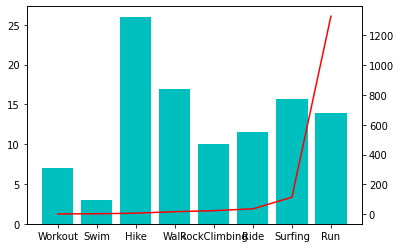

In [108]:
# let's plot our average kudos by activity and include log-scaled activity counts to help explain potential bias

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.bar(activity_count_df['type'], activity_count_df['average_kudos'], color='c')
ax2.plot(activity_count_df['type'], activity_count_df['count'], color='r')

plt.show()

### Preliminary look at correlation